In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  8%|█████                                                         | 4065/50000 [00:00<00:01, 40643.26it/s]

 17%|██████████▍                                                   | 8368/50000 [00:00<00:00, 42045.03it/s]

 25%|███████████████▎                                             | 12573/50000 [00:00<00:00, 40696.11it/s]

 34%|████████████████████▋                                        | 16965/50000 [00:00<00:00, 41943.34it/s]

 43%|██████████████████████████▏                                  | 21452/50000 [00:00<00:00, 42984.91it/s]

 52%|███████████████████████████████▍                             | 25756/50000 [00:00<00:00, 42579.55it/s]

 60%|████████████████████████████████████▌                        | 30018/50000 [00:00<00:00, 42237.74it/s]

 68%|█████████████████████████████████████████▊                   | 34245/50000 [00:00<00:00, 42041.63it/s]

 77%|██████████████████████████████████████████████▉              | 38451/50000 [00:00<00:00, 41862.15it/s]

 85%|████████████████████████████████████████████████████         | 42667/50000 [00:01<00:00, 41951.96it/s]

 94%|█████████████████████████████████████████████████████████▏   | 46922/50000 [00:01<00:00, 42131.26it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 42119.84it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 45%|███████████████████████████▋                                  | 4474/10000 [00:00<00:00, 44738.76it/s]

 89%|███████████████████████████████████████████████████████▍      | 8948/10000 [00:00<00:00, 44586.25it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 44558.49it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 xfy981ny


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-xfy981ny:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/313 [00:00<02:38,  1.97it/s]

  3%|█▊                                                                    | 8/313 [00:00<00:18, 16.70it/s]

  5%|███▎                                                                 | 15/313 [00:00<00:10, 28.76it/s]

  7%|████▊                                                                | 22/313 [00:00<00:07, 38.26it/s]

  9%|██████▍                                                              | 29/313 [00:00<00:06, 45.51it/s]

 12%|███████▉                                                             | 36/313 [00:01<00:05, 50.92it/s]

 14%|█████████▍                                                           | 43/313 [00:01<00:04, 54.89it/s]

 16%|███████████                                                          | 50/313 [00:01<00:04, 57.77it/s]

 18%|████████████▌                                                        | 57/313 [00:01<00:04, 59.84it/s]

 20%|██████████████                                                       | 64/313 [00:01<00:04, 61.29it/s]

 23%|███████████████▋                                                     | 71/313 [00:01<00:03, 62.34it/s]

 25%|█████████████████▏                                                   | 78/313 [00:01<00:03, 63.08it/s]

 27%|██████████████████▋                                                  | 85/313 [00:01<00:03, 63.60it/s]

 29%|████████████████████▎                                                | 92/313 [00:01<00:03, 63.97it/s]

 32%|█████████████████████▊                                               | 99/313 [00:02<00:03, 64.20it/s]

 34%|███████████████████████                                             | 106/313 [00:02<00:03, 64.36it/s]

 36%|████████████████████████▌                                           | 113/313 [00:02<00:03, 64.51it/s]

 38%|██████████████████████████                                          | 120/313 [00:02<00:02, 64.58it/s]

 41%|███████████████████████████▌                                        | 127/313 [00:02<00:02, 64.66it/s]

 43%|█████████████████████████████                                       | 134/313 [00:02<00:02, 64.71it/s]

 45%|██████████████████████████████▋                                     | 141/313 [00:02<00:02, 64.73it/s]

 47%|████████████████████████████████▏                                   | 148/313 [00:02<00:02, 64.65it/s]

 50%|█████████████████████████████████▋                                  | 155/313 [00:02<00:02, 64.63it/s]

 52%|███████████████████████████████████▏                                | 162/313 [00:02<00:02, 64.68it/s]

 54%|████████████████████████████████████▋                               | 169/313 [00:03<00:02, 64.74it/s]

 56%|██████████████████████████████████████▏                             | 176/313 [00:03<00:02, 64.74it/s]

 58%|███████████████████████████████████████▊                            | 183/313 [00:03<00:02, 64.77it/s]

 61%|█████████████████████████████████████████▎                          | 190/313 [00:03<00:01, 64.80it/s]

 63%|██████████████████████████████████████████▊                         | 197/313 [00:03<00:01, 64.78it/s]

 65%|████████████████████████████████████████████▎                       | 204/313 [00:03<00:01, 64.80it/s]

 67%|█████████████████████████████████████████████▊                      | 211/313 [00:03<00:01, 64.82it/s]

 70%|███████████████████████████████████████████████▎                    | 218/313 [00:03<00:01, 64.84it/s]

 72%|████████████████████████████████████████████████▉                   | 225/313 [00:03<00:01, 64.79it/s]

 74%|██████████████████████████████████████████████████▍                 | 232/313 [00:04<00:01, 64.79it/s]

 76%|███████████████████████████████████████████████████▉                | 239/313 [00:04<00:01, 64.80it/s]

 79%|█████████████████████████████████████████████████████▍              | 246/313 [00:04<00:01, 64.74it/s]

 81%|██████████████████████████████████████████████████████▉             | 253/313 [00:04<00:00, 64.66it/s]

 83%|████████████████████████████████████████████████████████▍           | 260/313 [00:04<00:00, 64.64it/s]

 85%|██████████████████████████████████████████████████████████          | 267/313 [00:04<00:00, 64.63it/s]

 88%|███████████████████████████████████████████████████████████▌        | 274/313 [00:04<00:00, 64.68it/s]

 90%|█████████████████████████████████████████████████████████████       | 281/313 [00:04<00:00, 64.69it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 288/313 [00:04<00:00, 64.73it/s]

 94%|████████████████████████████████████████████████████████████████    | 295/313 [00:05<00:00, 64.75it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 302/313 [00:05<00:00, 64.77it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 309/313 [00:05<00:00, 64.72it/s]

100%|████████████████████████████████████████████████████████████████████| 313/313 [00:05<00:00, 58.27it/s]

train - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  4%|██▋                                                                    | 3/79 [00:00<00:02, 28.34it/s]

 13%|████████▊                                                             | 10/79 [00:00<00:01, 49.68it/s]

 22%|███████████████                                                       | 17/79 [00:00<00:01, 56.45it/s]

 30%|█████████████████████▎                                                | 24/79 [00:00<00:00, 59.65it/s]

 39%|███████████████████████████▍                                          | 31/79 [00:00<00:00, 61.42it/s]

 48%|█████████████████████████████████▋                                    | 38/79 [00:00<00:00, 62.49it/s]

 57%|███████████████████████████████████████▊                              | 45/79 [00:00<00:00, 63.19it/s]

 66%|██████████████████████████████████████████████                        | 52/79 [00:00<00:00, 63.64it/s]

 75%|████████████████████████████████████████████████████▎                 | 59/79 [00:00<00:00, 63.88it/s]

 84%|██████████████████████████████████████████████████████████▍           | 66/79 [00:01<00:00, 64.10it/s]

 92%|████████████████████████████████████████████████████████████████▋     | 73/79 [00:01<00:00, 64.25it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.89it/s]

val - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  4%|██▋                                                                    | 3/79 [00:00<00:02, 27.13it/s]

 13%|████████▊                                                             | 10/79 [00:00<00:01, 48.76it/s]

 22%|███████████████                                                       | 17/79 [00:00<00:01, 55.89it/s]

 30%|█████████████████████▎                                                | 24/79 [00:00<00:00, 59.31it/s]

 39%|███████████████████████████▍                                          | 31/79 [00:00<00:00, 60.92it/s]

 48%|█████████████████████████████████▋                                    | 38/79 [00:00<00:00, 62.15it/s]

 57%|███████████████████████████████████████▊                              | 45/79 [00:00<00:00, 62.89it/s]

 66%|██████████████████████████████████████████████                        | 52/79 [00:00<00:00, 61.70it/s]

 75%|████████████████████████████████████████████████████▎                 | 59/79 [00:01<00:00, 60.08it/s]

 84%|██████████████████████████████████████████████████████████▍           | 66/79 [00:01<00:00, 58.88it/s]

 91%|███████████████████████████████████████████████████████████████▊      | 72/79 [00:01<00:00, 58.15it/s]

 99%|█████████████████████████████████████████████████████████████████████ | 78/79 [00:01<00:00, 57.89it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.40it/s]

test InD - OK


  0%|                                                                              | 0/469 [00:00<?, ?it/s]

  0%|▎                                                                     | 2/469 [00:00<00:25, 18.54it/s]

  2%|█▎                                                                    | 9/469 [00:00<00:10, 44.43it/s]

  3%|██▎                                                                  | 16/469 [00:00<00:08, 53.50it/s]

  5%|███▍                                                                 | 23/469 [00:00<00:07, 57.85it/s]

  6%|████▍                                                                | 30/469 [00:00<00:07, 59.41it/s]

  8%|█████▎                                                               | 36/469 [00:00<00:07, 58.42it/s]

  9%|██████▏                                                              | 42/469 [00:00<00:07, 57.96it/s]

 10%|███████▏                                                             | 49/469 [00:00<00:06, 60.09it/s]

 12%|████████▏                                                            | 56/469 [00:01<00:09, 43.89it/s]

 13%|█████████                                                            | 62/469 [00:01<00:09, 44.74it/s]

 15%|██████████▏                                                          | 69/469 [00:01<00:08, 48.70it/s]

 16%|███████████                                                          | 75/469 [00:01<00:07, 50.01it/s]

 17%|███████████▉                                                         | 81/469 [00:01<00:08, 44.97it/s]

 18%|████████████▋                                                        | 86/469 [00:01<00:09, 42.30it/s]

 19%|█████████████▍                                                       | 91/469 [00:01<00:09, 40.08it/s]

 20%|██████████████                                                       | 96/469 [00:02<00:09, 38.77it/s]

 21%|██████████████▍                                                     | 100/469 [00:02<00:09, 38.08it/s]

 22%|███████████████                                                     | 104/469 [00:02<00:09, 37.52it/s]

 23%|███████████████▋                                                    | 108/469 [00:02<00:09, 37.09it/s]

 24%|████████████████▏                                                   | 112/469 [00:02<00:09, 36.90it/s]

 25%|████████████████▊                                                   | 116/469 [00:02<00:09, 36.52it/s]

 26%|█████████████████▍                                                  | 120/469 [00:02<00:09, 36.39it/s]

 26%|█████████████████▉                                                  | 124/469 [00:02<00:09, 36.36it/s]

 27%|██████████████████▌                                                 | 128/469 [00:02<00:09, 36.32it/s]

 28%|███████████████████▏                                                | 132/469 [00:03<00:09, 36.29it/s]

 29%|███████████████████▋                                                | 136/469 [00:03<00:09, 36.19it/s]

 30%|████████████████████▎                                               | 140/469 [00:03<00:09, 35.93it/s]

 31%|████████████████████▉                                               | 144/469 [00:03<00:09, 35.74it/s]

 32%|█████████████████████▍                                              | 148/469 [00:03<00:08, 35.86it/s]

 32%|██████████████████████                                              | 152/469 [00:03<00:08, 35.97it/s]

 33%|██████████████████████▌                                             | 156/469 [00:03<00:08, 36.05it/s]

 34%|███████████████████████▏                                            | 160/469 [00:03<00:08, 35.86it/s]

 35%|███████████████████████▊                                            | 164/469 [00:03<00:08, 35.79it/s]

 36%|████████████████████████▎                                           | 168/469 [00:04<00:08, 35.96it/s]

 37%|████████████████████████▉                                           | 172/469 [00:04<00:08, 35.85it/s]

 38%|█████████████████████████▌                                          | 176/469 [00:04<00:08, 35.67it/s]

 38%|██████████████████████████                                          | 180/469 [00:04<00:08, 35.63it/s]

 39%|██████████████████████████▋                                         | 184/469 [00:04<00:07, 35.63it/s]

 40%|███████████████████████████▎                                        | 188/469 [00:04<00:07, 35.48it/s]

 41%|███████████████████████████▊                                        | 192/469 [00:04<00:07, 35.51it/s]

 42%|████████████████████████████▍                                       | 196/469 [00:04<00:07, 35.43it/s]

 43%|████████████████████████████▉                                       | 200/469 [00:04<00:07, 35.61it/s]

 43%|█████████████████████████████▌                                      | 204/469 [00:05<00:07, 35.83it/s]

 44%|██████████████████████████████▏                                     | 208/469 [00:05<00:07, 35.88it/s]

 45%|██████████████████████████████▋                                     | 212/469 [00:05<00:07, 35.47it/s]

 46%|███████████████████████████████▎                                    | 216/469 [00:05<00:07, 35.61it/s]

 47%|███████████████████████████████▉                                    | 220/469 [00:05<00:06, 35.83it/s]

 48%|████████████████████████████████▍                                   | 224/469 [00:05<00:06, 35.75it/s]

 49%|█████████████████████████████████                                   | 228/469 [00:05<00:06, 35.73it/s]

 49%|█████████████████████████████████▋                                  | 232/469 [00:05<00:06, 35.71it/s]

 50%|██████████████████████████████████▏                                 | 236/469 [00:05<00:06, 35.13it/s]

 51%|██████████████████████████████████▊                                 | 240/469 [00:06<00:06, 35.17it/s]

 52%|███████████████████████████████████▍                                | 244/469 [00:06<00:06, 35.22it/s]

 53%|███████████████████████████████████▉                                | 248/469 [00:06<00:06, 35.25it/s]

 54%|████████████████████████████████████▌                               | 252/469 [00:06<00:06, 35.31it/s]

 55%|█████████████████████████████████████                               | 256/469 [00:06<00:06, 35.33it/s]

 55%|█████████████████████████████████████▋                              | 260/469 [00:06<00:05, 35.36it/s]

 56%|██████████████████████████████████████▎                             | 264/469 [00:06<00:05, 35.57it/s]

 57%|██████████████████████████████████████▊                             | 268/469 [00:06<00:05, 35.56it/s]

 58%|███████████████████████████████████████▍                            | 272/469 [00:06<00:05, 35.44it/s]

 59%|████████████████████████████████████████                            | 276/469 [00:07<00:05, 35.48it/s]

 60%|████████████████████████████████████████▌                           | 280/469 [00:07<00:05, 35.26it/s]

 61%|█████████████████████████████████████████▏                          | 284/469 [00:07<00:05, 35.16it/s]

 61%|█████████████████████████████████████████▊                          | 288/469 [00:07<00:05, 35.30it/s]

 62%|██████████████████████████████████████████▎                         | 292/469 [00:07<00:05, 35.31it/s]

 63%|██████████████████████████████████████████▉                         | 296/469 [00:07<00:04, 35.34it/s]

 64%|███████████████████████████████████████████▍                        | 300/469 [00:07<00:04, 35.32it/s]

 65%|████████████████████████████████████████████                        | 304/469 [00:07<00:04, 35.31it/s]

 66%|████████████████████████████████████████████▋                       | 308/469 [00:08<00:04, 35.33it/s]

 67%|█████████████████████████████████████████████▏                      | 312/469 [00:08<00:04, 35.55it/s]

 67%|█████████████████████████████████████████████▊                      | 316/469 [00:08<00:04, 35.55it/s]

 68%|██████████████████████████████████████████████▍                     | 320/469 [00:08<00:04, 35.51it/s]

 69%|██████████████████████████████████████████████▉                     | 324/469 [00:08<00:04, 35.53it/s]

 70%|███████████████████████████████████████████████▌                    | 328/469 [00:08<00:03, 35.53it/s]

 71%|████████████████████████████████████████████████▏                   | 332/469 [00:08<00:03, 35.42it/s]

 72%|████████████████████████████████████████████████▋                   | 336/469 [00:08<00:03, 34.99it/s]

 72%|█████████████████████████████████████████████████▎                  | 340/469 [00:08<00:03, 35.11it/s]

 73%|█████████████████████████████████████████████████▉                  | 344/469 [00:09<00:03, 35.42it/s]

 74%|██████████████████████████████████████████████████▍                 | 348/469 [00:09<00:03, 35.16it/s]

 75%|███████████████████████████████████████████████████                 | 352/469 [00:09<00:03, 35.12it/s]

 76%|███████████████████████████████████████████████████▌                | 356/469 [00:09<00:03, 34.87it/s]

 77%|████████████████████████████████████████████████████▏               | 360/469 [00:09<00:03, 35.09it/s]

 78%|████████████████████████████████████████████████████▊               | 364/469 [00:09<00:03, 34.91it/s]

 78%|█████████████████████████████████████████████████████▎              | 368/469 [00:09<00:02, 34.86it/s]

 79%|█████████████████████████████████████████████████████▉              | 372/469 [00:09<00:02, 35.04it/s]

 80%|██████████████████████████████████████████████████████▌             | 376/469 [00:09<00:02, 35.19it/s]

 81%|███████████████████████████████████████████████████████             | 380/469 [00:10<00:02, 35.50it/s]

 82%|███████████████████████████████████████████████████████▋            | 384/469 [00:10<00:02, 35.76it/s]

 83%|████████████████████████████████████████████████████████▎           | 388/469 [00:10<00:02, 35.70it/s]

 84%|████████████████████████████████████████████████████████▊           | 392/469 [00:10<00:02, 35.64it/s]

 84%|█████████████████████████████████████████████████████████▍          | 396/469 [00:10<00:02, 35.61it/s]

 85%|█████████████████████████████████████████████████████████▉          | 400/469 [00:10<00:01, 35.30it/s]

 86%|██████████████████████████████████████████████████████████▌         | 404/469 [00:10<00:01, 35.09it/s]

 87%|███████████████████████████████████████████████████████████▏        | 408/469 [00:10<00:01, 35.43it/s]

 88%|███████████████████████████████████████████████████████████▋        | 412/469 [00:10<00:01, 35.48it/s]

 89%|████████████████████████████████████████████████████████████▎       | 416/469 [00:11<00:01, 35.72it/s]

 90%|████████████████████████████████████████████████████████████▉       | 420/469 [00:11<00:01, 35.66it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 424/469 [00:11<00:01, 35.87it/s]

 91%|██████████████████████████████████████████████████████████████      | 428/469 [00:11<00:01, 35.71it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 432/469 [00:11<00:01, 35.64it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 436/469 [00:11<00:00, 35.61it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 440/469 [00:11<00:00, 35.73it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 444/469 [00:11<00:00, 35.49it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 448/469 [00:11<00:00, 35.52it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 452/469 [00:12<00:00, 35.45it/s]

 97%|██████████████████████████████████████████████████████████████████  | 456/469 [00:12<00:00, 35.53it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 460/469 [00:12<00:00, 35.71it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 464/469 [00:12<00:00, 35.63it/s]

100%|███████████████████████████████████████████████████████████████████▊| 468/469 [00:12<00:00, 35.58it/s]

100%|████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.18it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:02, 36.55it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:02, 34.82it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:02, 34.96it/s]

 16%|███████████                                                          | 16/100 [00:00<00:02, 35.06it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:02, 35.45it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:02, 35.30it/s]

 28%|███████████████████▎                                                 | 28/100 [00:00<00:02, 34.88it/s]

 32%|██████████████████████                                               | 32/100 [00:00<00:01, 34.57it/s]

 36%|████████████████████████▊                                            | 36/100 [00:01<00:01, 34.77it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:01<00:01, 34.99it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:01<00:01, 35.15it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:01<00:01, 35.23it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:01<00:01, 35.28it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:01<00:01, 35.34it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:01<00:01, 35.02it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:01<00:01, 35.12it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:01<00:00, 35.24it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:02<00:00, 35.27it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:02<00:00, 35.29it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:02<00:00, 35.34it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:02<00:00, 35.36it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:02<00:00, 35.38it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 35.17it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:02<00:00, 35.49it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.40it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.20it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


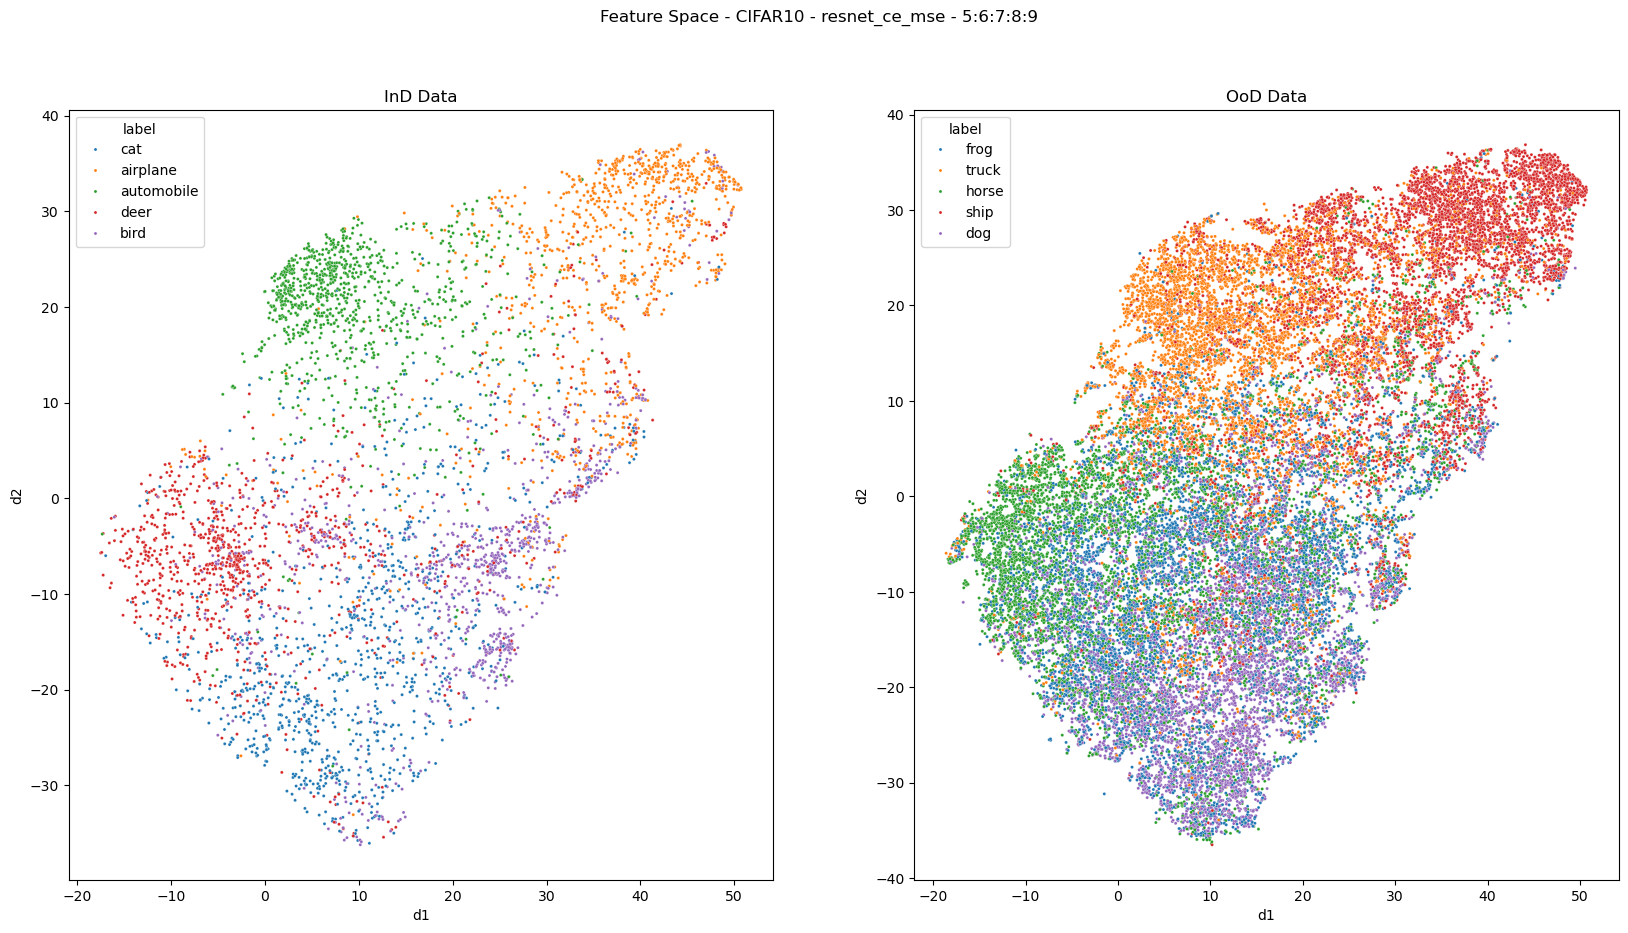

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

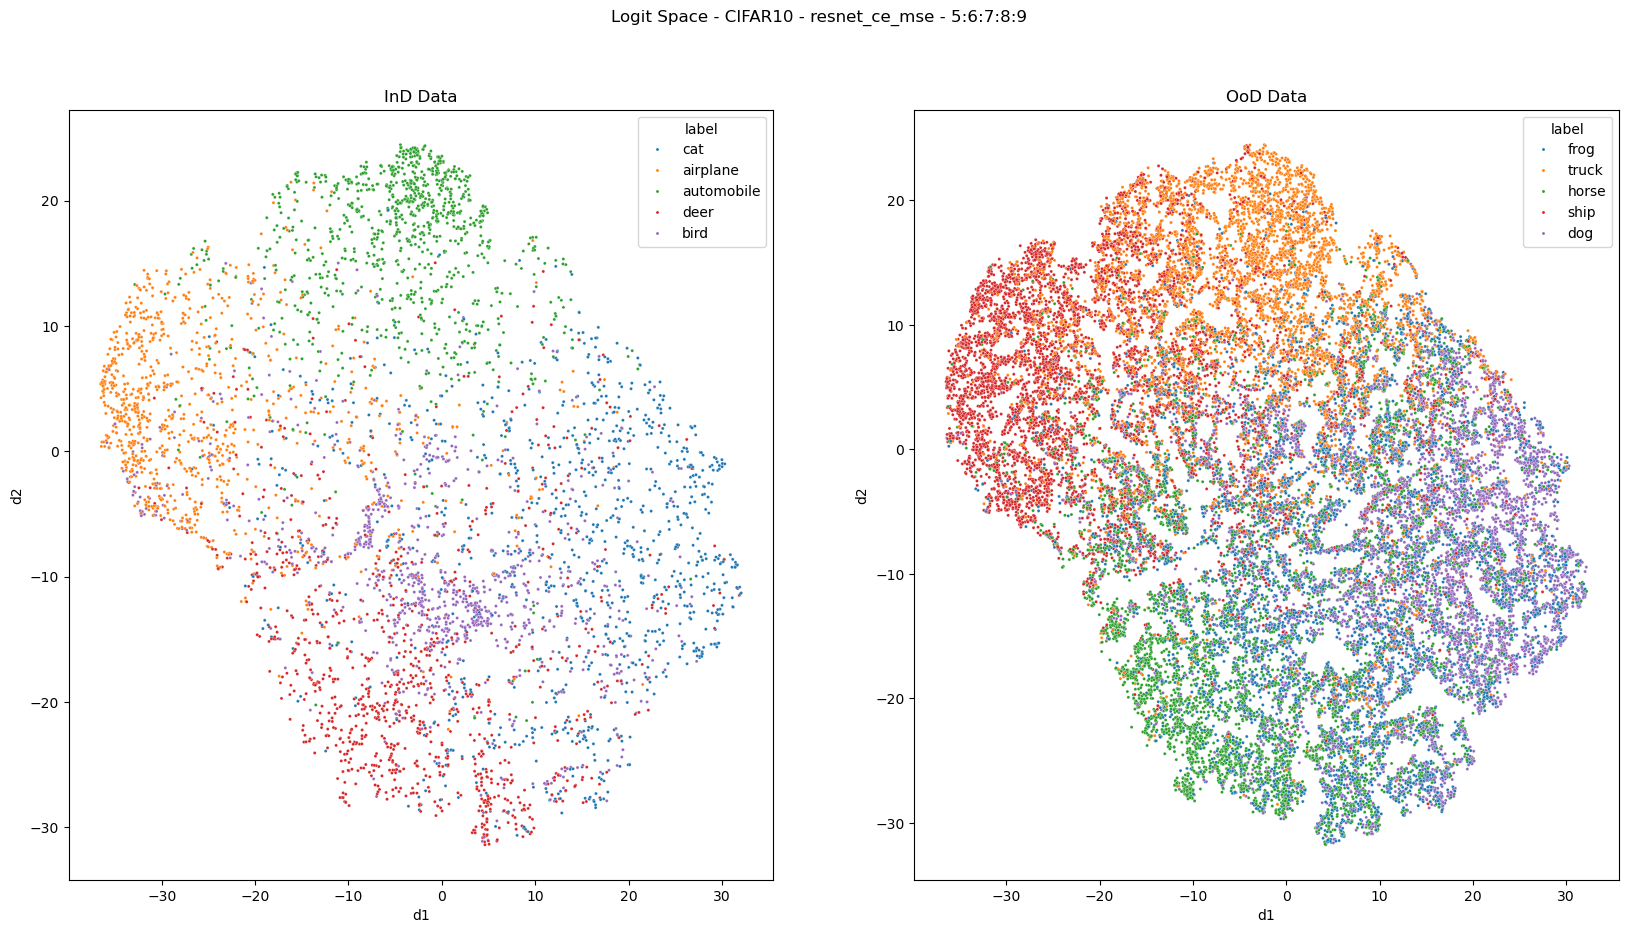

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.42s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.52s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:04<00:01,  1.52s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/it]

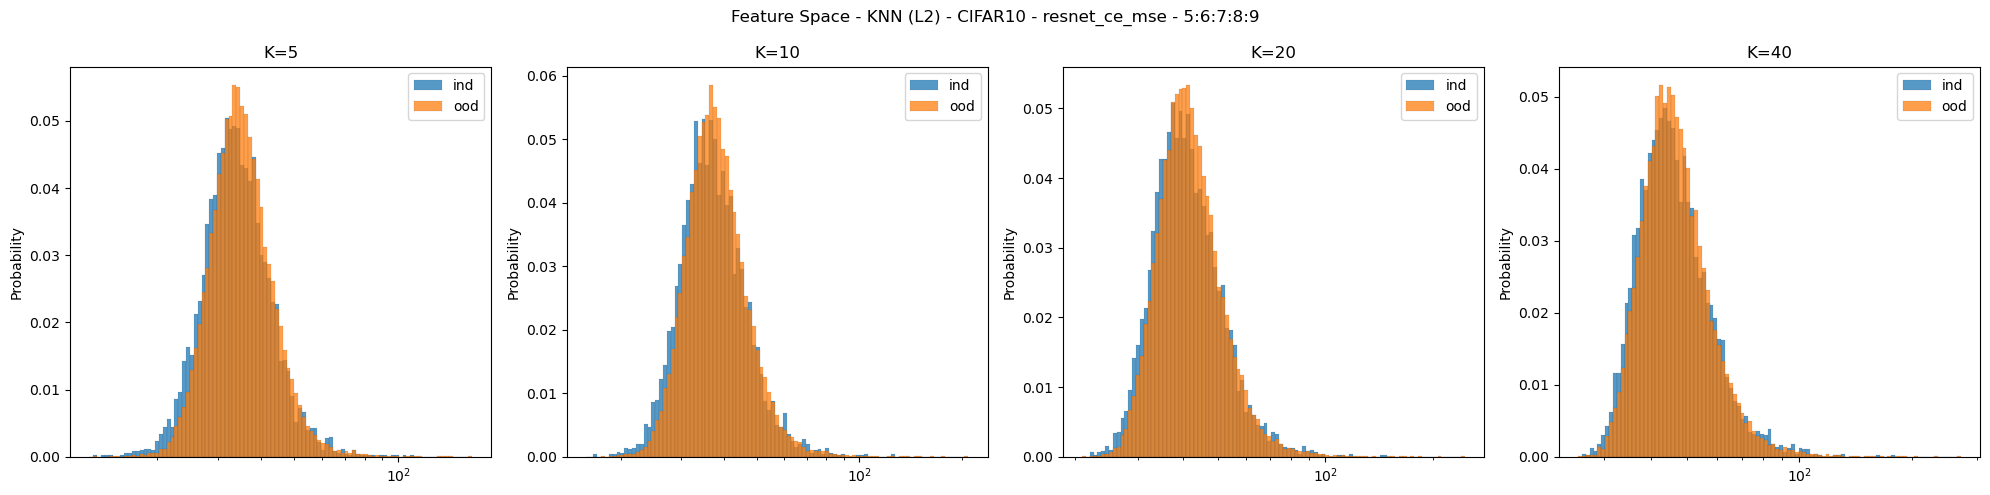

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.37s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.39s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:04<00:01,  1.43s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.59s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]

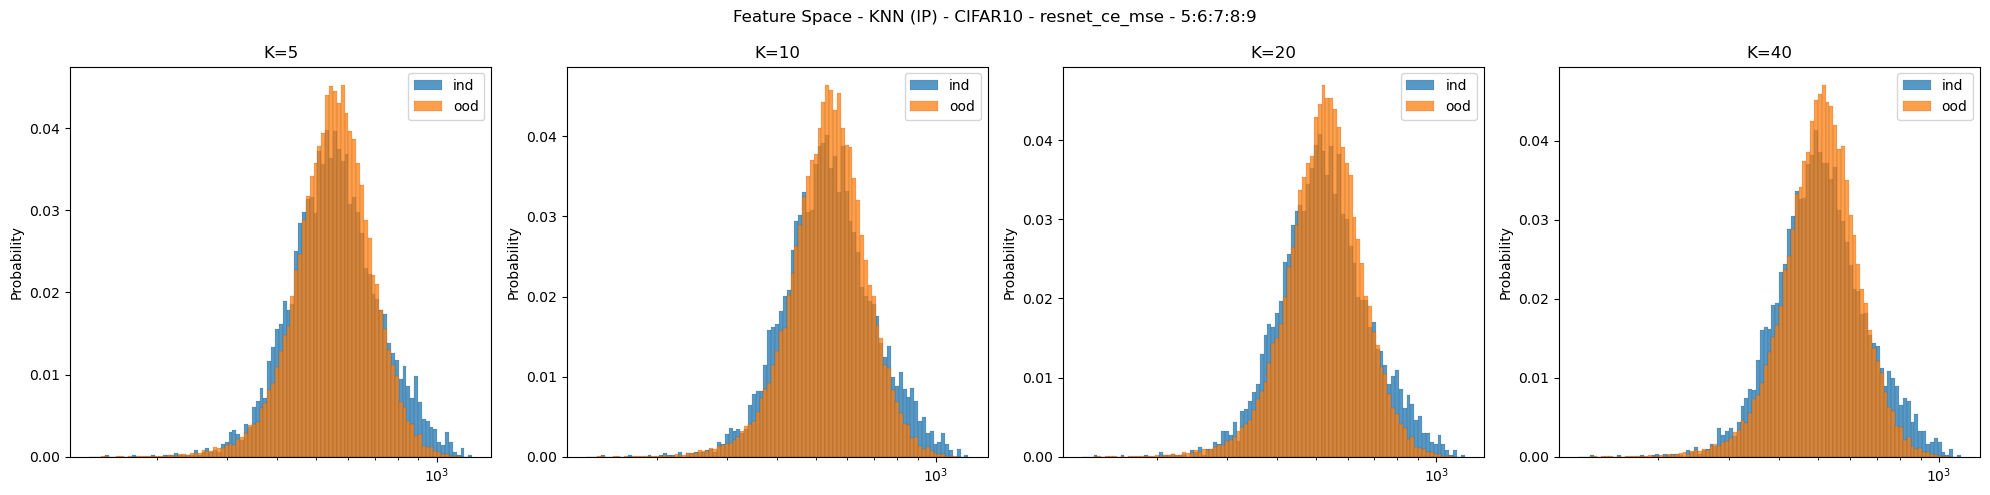

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.14it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.97it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.63it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]

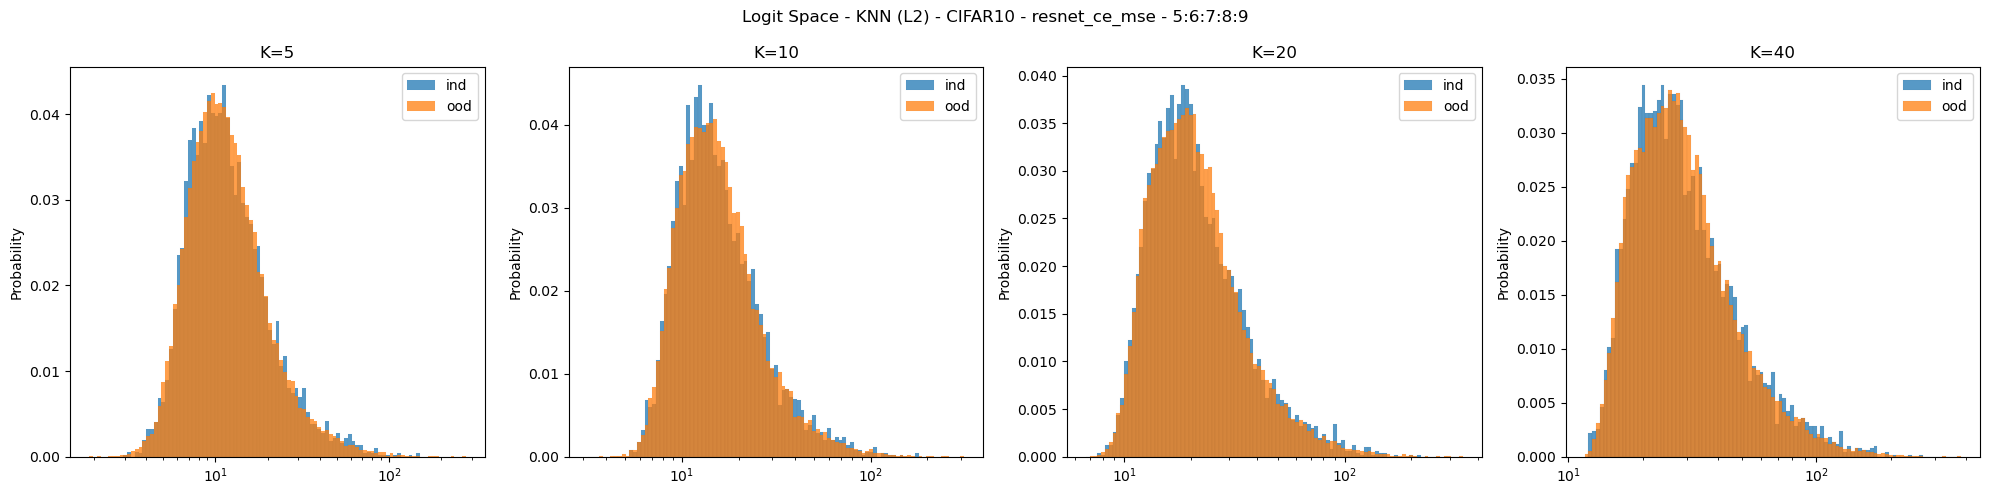

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.39it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  3.17it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.16it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.98it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]

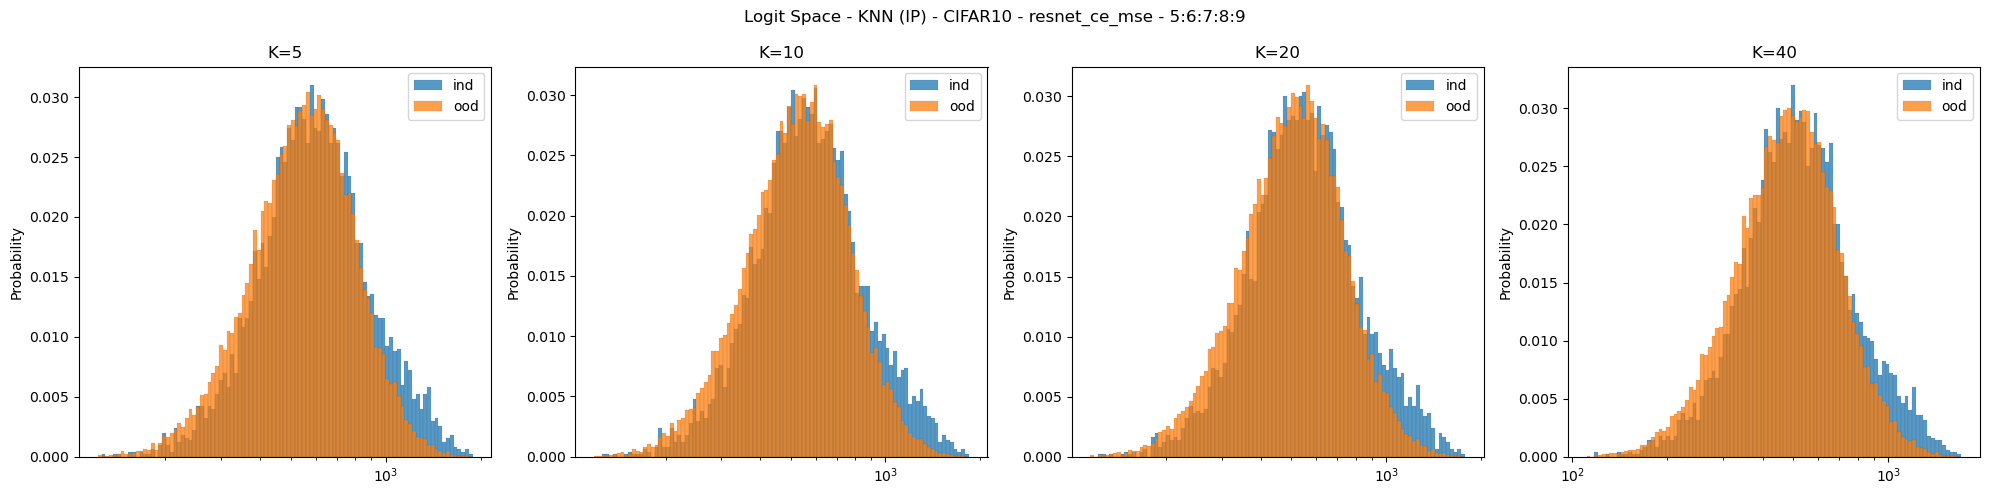

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

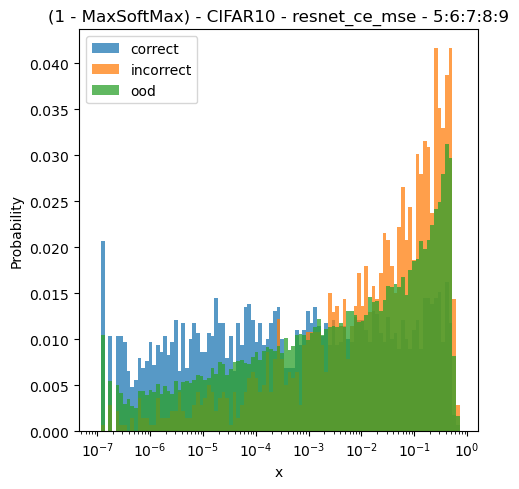

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

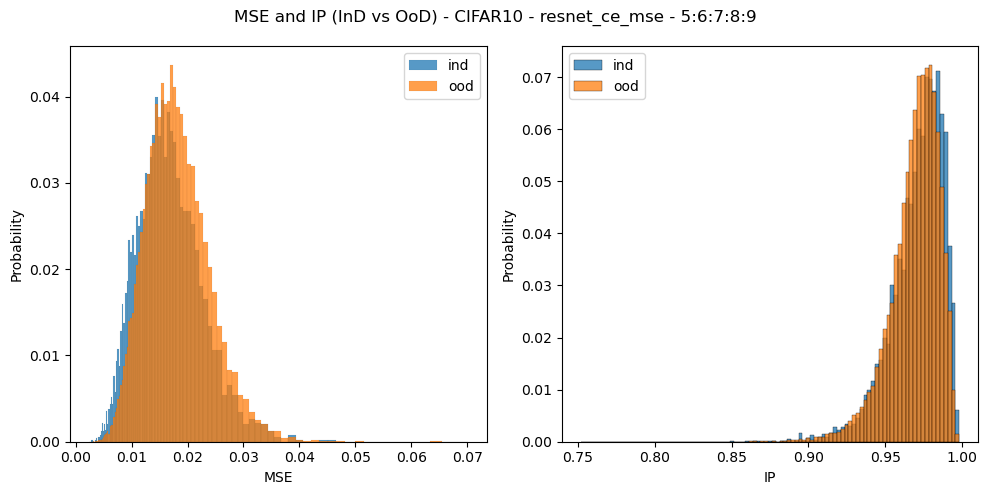

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()